# Foraging locust with dynamical systems (interpretation)


In this notebook, we briefly explain how the estimated parameters of the dynamical systems model are to be interpreted.

In [1]:
import os

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns

pyro.settings.set(module_local_params=True)

sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns

from collab.foraging import locust as lc
from collab.utils import find_repo_root

In [2]:
locds = lc.LocustDS(
    data_code="15EQ20191202",
    start=0,
    end=10,
)

locds.run_inference(
    "length",
    num_iterations=1500,
    num_samples=150,
    lr=0.001,  # force=True, save=True
)

Loading inference samples


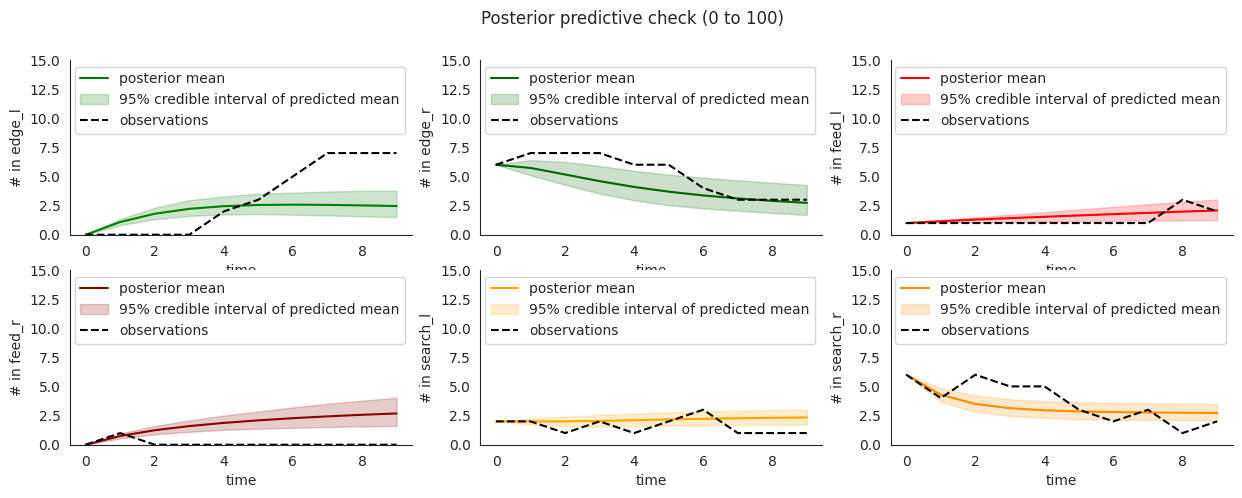

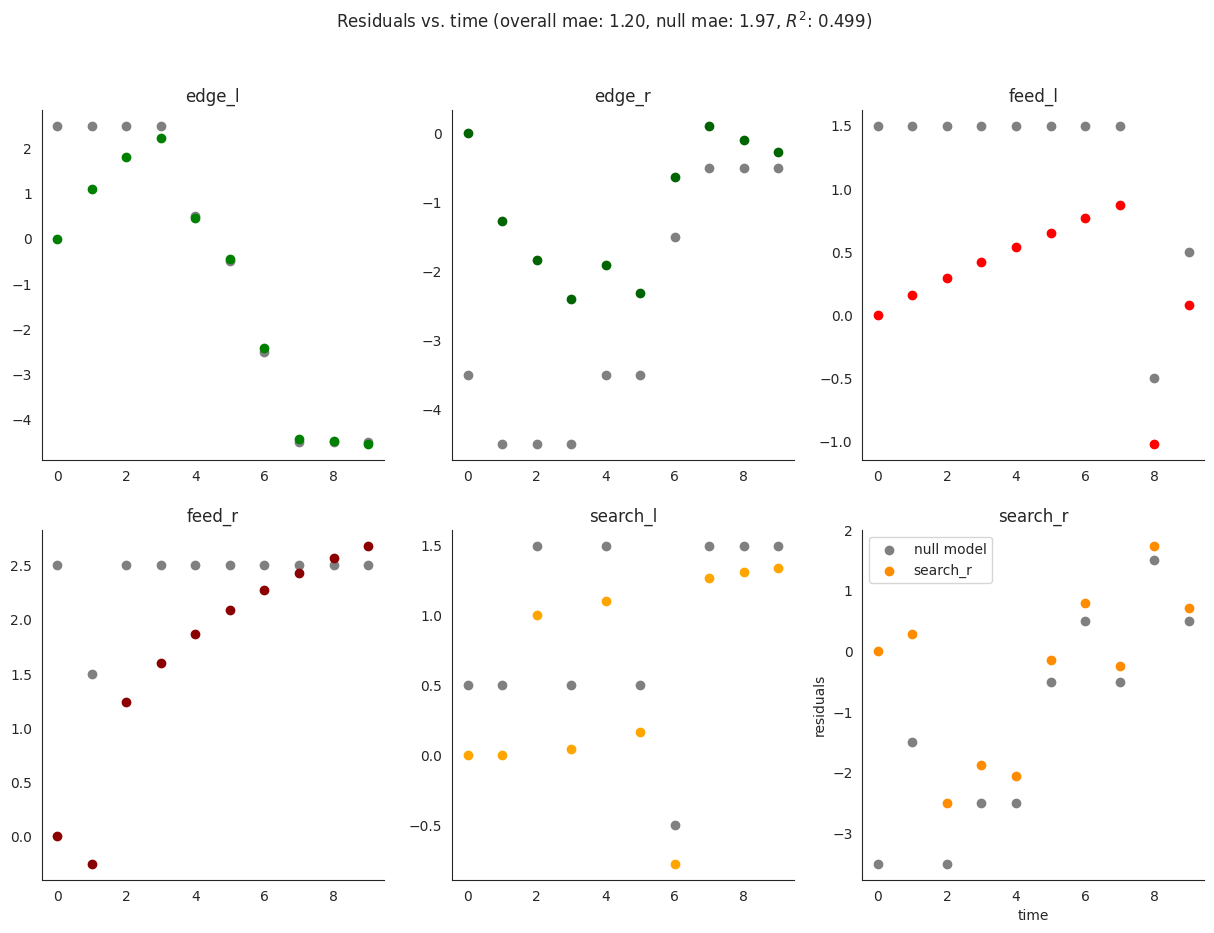

In [4]:
# first sanity check
locds.posterior_check()
locds.evaluate(samples=locds.samples, subset=locds.subset)

Loading validation samples


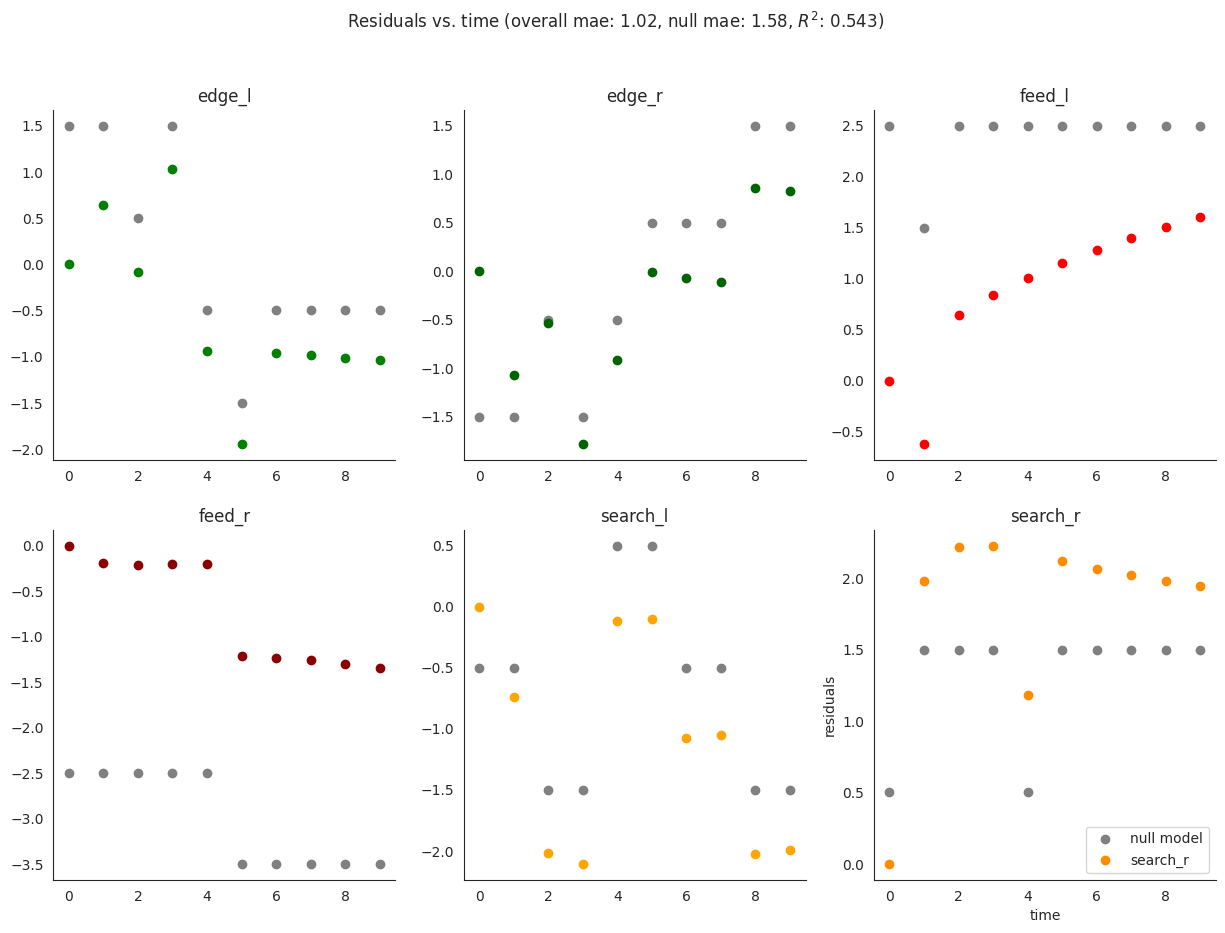

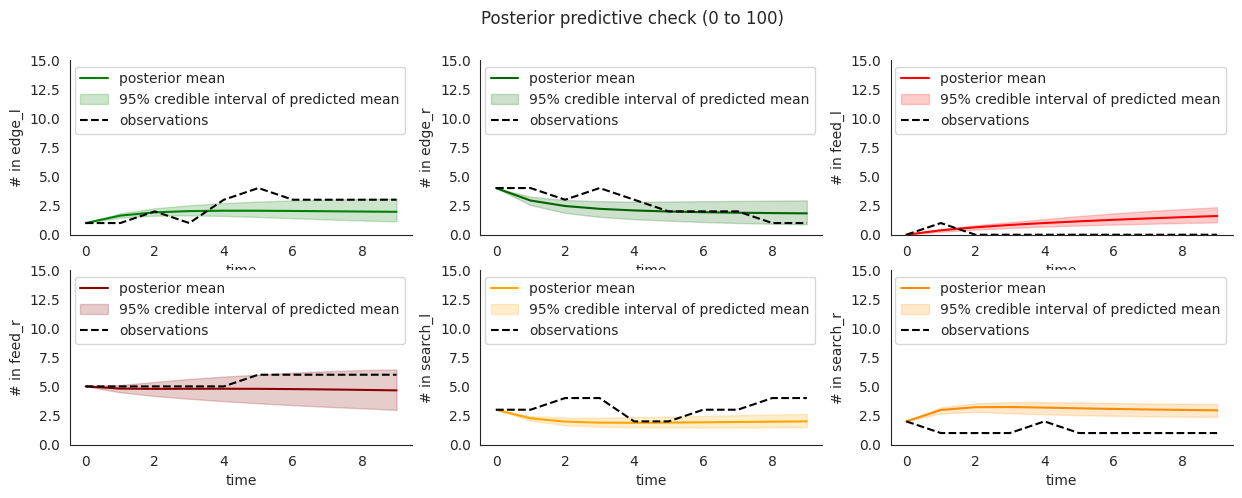

In [6]:
# validation
locds.validate(
    validation_data_code="15EQ20191205",
)  # force=True, save=True)
locds.posterior_check(samples=locds.v_samples, subset=locds.v_subset)

Now we inspect the third "wondering" parameter and the fourth "attraction" product term. `w_feed` is the term that captures those locusts that are searchers (neither moving around the edge, nor feeding) and move towards food (on the left or on the right) just by exploration:

```
w_searchers_lf = w_feed * X["search_l"]
w_searchers_rf = w_feed * X["search_r"]

dX["search_l"]  = ... - w_searchers_lf ...
dX["feed_l"] = ... + w_searchers_lf  ...
```

In contrast, `a_feed` is a product coefficient, used in more flux terms. It captures the attraction of edgers (left/right) towards the feeding units - these flux terms are used to move edgers towards the next available compartment between edgers and feeding, i.e. searchers.

```
a_edgers_lf = a_feed * X["edge_l"] * X["feed_l"]
a_edgers_rf = a_feed * X["edge_r"] * X["feed_r"]

dX["search_l"] = ... + a_edgers_lf  ....
dX["edge_l"] =  ... - - a_edgers_lf  ...

```

It also is assumed to capture the attraction of searchers to feeding units:

```
a_searchers_lf = a_feed * X["search_l"] * X["feed_l"]
a_searchers_rf = a_feed * X["search_r"] * X["feed_r"]

dx["search_l] = ... - a_searchers_lf  ...
dX["feed_l"] =  ...  + a_searchers_lf ...
```


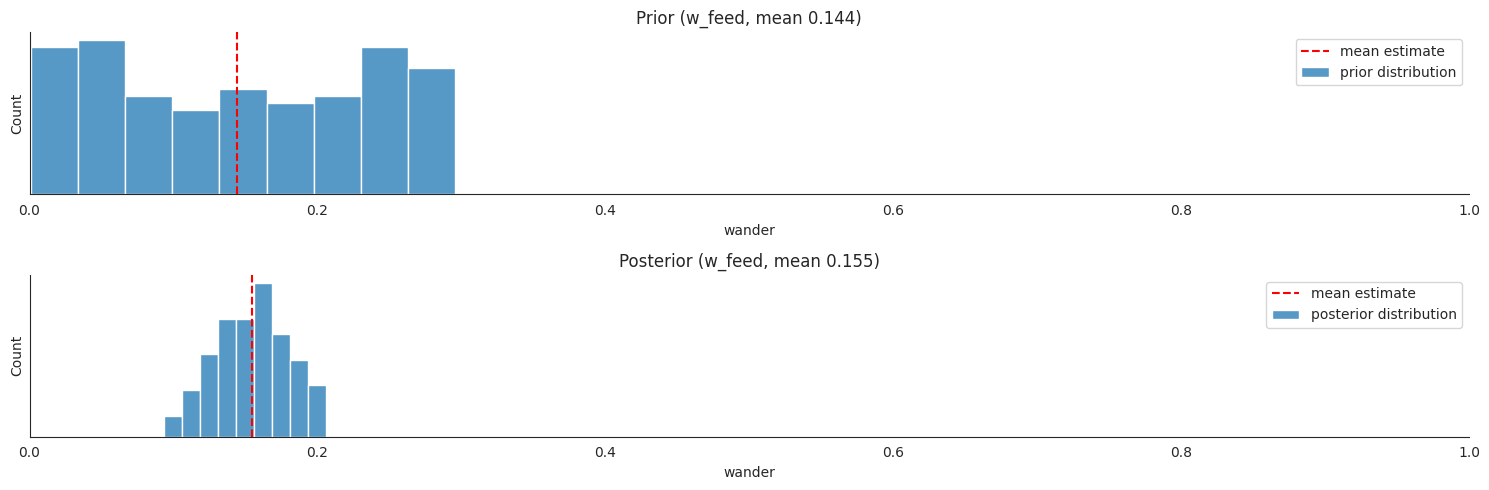

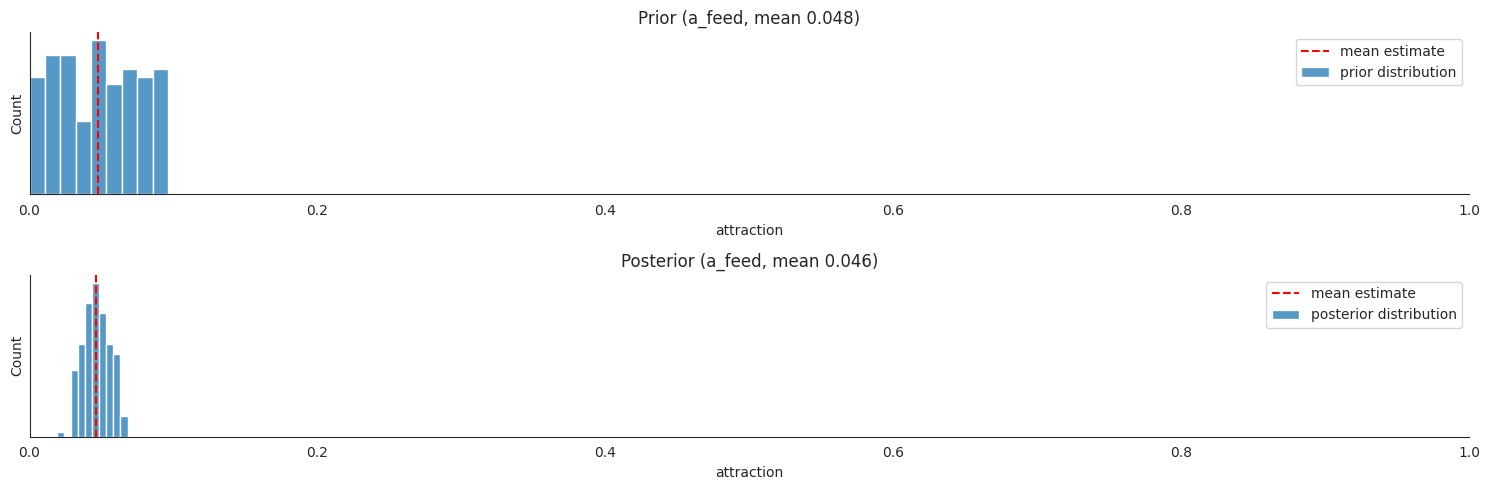

In [5]:
locds.get_prior_samples(num_samples=150)
locds.plot_param_estimates(3, 4)

The key conceptual point here is that the `w_`-terms and the `a_terms`-are not on the same scale. The `w_`-terms are ratios of origin compartments expected to depart at a time step, whereas to get an analogous ration using an `a_`-term, we need to first multiply it by the locust count at the target compartment. Here's a visualization of how such a ratio depends on the target compartment counts for a realistic range of values (1-9).

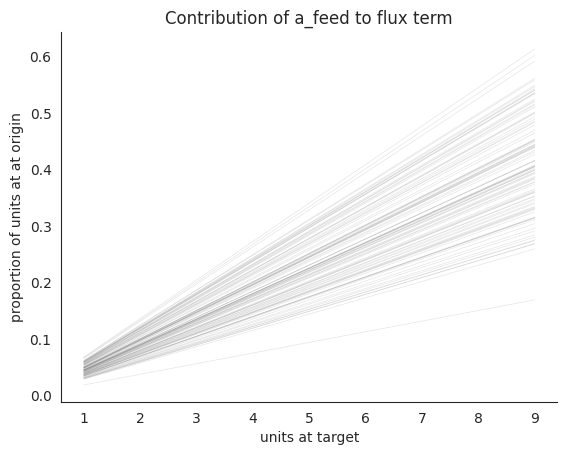

In [6]:
lc.plot_ds_interaction(locds.samples, "attraction", 4, xlim=10, num_lines=100)

Another point we investigated was whether the estimated `a_feed` parameter changes depending on the time window start, corresponding to the question of whether the locusts change their attraction to feeder throughout the experiment. 

In [7]:
data_code = "15EQ20191202"

samples_a_feed_10 = []

root = find_repo_root()
data_path = os.path.join(root, f"data/foraging/locust/ds/locust_samples_a_feed_10.pkl")

if os.path.exists(data_path):
    with open(data_path, "rb") as f:
        samples_a_feed_10 = dill.load(f)
else:
    for start in [0, 30, 60, 90, 120, 150]:
        print(start)
        locds = lc.LocustDS(
            data_code=data_code,
            start=start,
            end=start + 10,
        )

        locds.run_inference("length", num_iterations=1500, num_samples=150, lr=0.001)
        samples_a_feed_10.append(locds.samples["attraction"][:, 4])

    with open(data_path, "wb") as f:
        dill.dump(samples_a_feed_10, f)

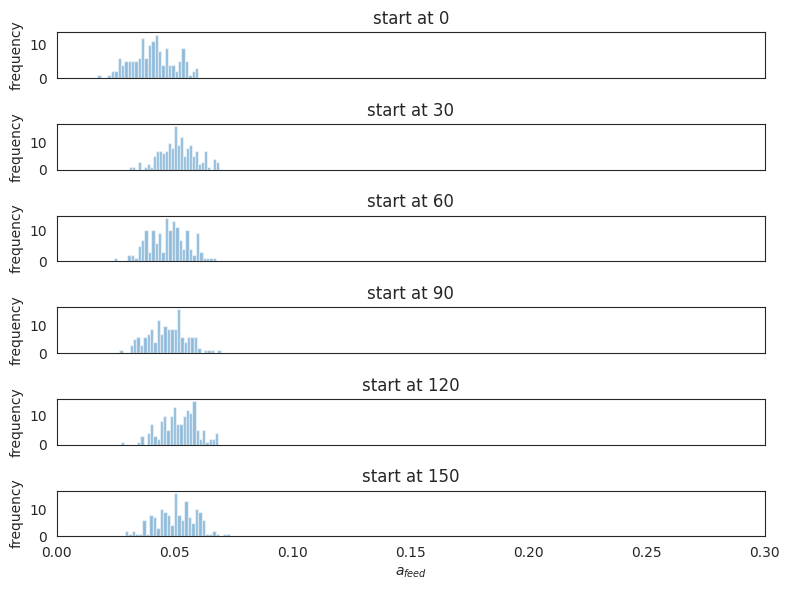

In [8]:
start = [0, 30, 60, 90, 120, 150]

fig, axs = plt.subplots(len(start), 1, figsize=(8, 6), sharex=True)

for i, (s, tensor) in enumerate(zip(start, samples_a_feed_10)):
    axs[i].hist(tensor, bins=30, alpha=0.5, label=f"start at {s}")
    axs[i].set_ylabel("frequency")
    axs[i].title.set_text(f"start at {s}")
    axs[i].set_xlim(0, 0.3)

axs[-1].set_xlabel("$a_{feed}$")
plt.tight_layout()
# plt.savefig("locust_a_feed_10_various_starts.png")
plt.show()